In [23]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import math

## Logistic Regression
- predicts categories instead of real numbers (classification)
- Logistic Regression does output a continous number, but that can be converted into a discrete number using threshold
- fairly resiliant against outliers
- the logistic function is a s-curve
- for set of input variables, it produces an output valuable between 0 and 1
- function for 1 input variable x:
- y = 1 / (1 + e**-(ß0 + ß1x))
- ß0 = b = intercept
- ß1 = m = slope
- function in the exponent is the log-odds function
- function for more than 1 input variables:
- y = 1 / (1 + e**-(ß0 + ß1x1 + ß2x2 + ß3x3....))

**Fitting Logistic Regression**
- input data can be decimal, integer or binary
- output has to be binary (0 or 1)
- when we do prediction, output will be between 0 and 1
- given input and output data, we solve for ß0 and ß1
- we dont minimize least squares like in regression
- but we use maximum likelyhood estimation
- which maximizes the likelyhood a given logistic curve would output the observed data

**Preparing and understanding the dataset**

In [13]:
# Load the data
df = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",")

# Extract input variables (all rows, all columns but last column)
X = df.values[:, :-1]

# Extract output column (all rows, last column)
Y = df.values[:, -1]

In [14]:
df.head()

,x,y
0,1.0,0
1,1.5,0
2,2.1,0
3,2.4,0
4,2.5,1


In [15]:
df.describe()

,x,y
count,21.000000,21.000000
mean,5.209524,0.571429
std,2.468786,0.507093
min,1.000000,0.000000
25%,3.100000,0.000000
50%,5.200000,1.000000
75%,7.000000,1.000000
max,9.200000,1.000000


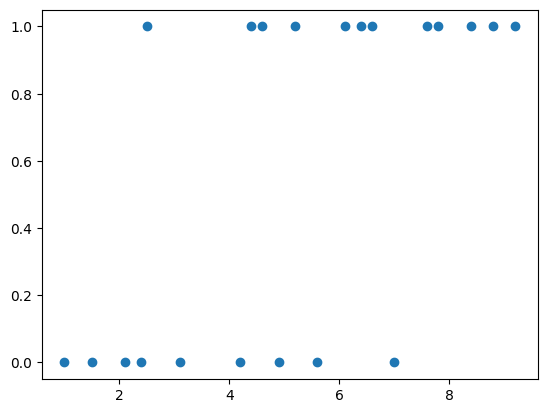

In [17]:
plt.plot(X,Y, "o")
plt.show()

**Logistic regression with sklearn**

In [20]:
# Perform logistic regression
# Turn off penalty
model = LogisticRegression(penalty=None)
model.fit(X, Y)

# print beta1
ß1 = model.coef_.flatten()
print(ß1) # 0.69267212

# print beta0
ß0 = model.intercept_.flatten()
print(ß0) # -3.17576395

[0.69267212]
[-3.17576395]


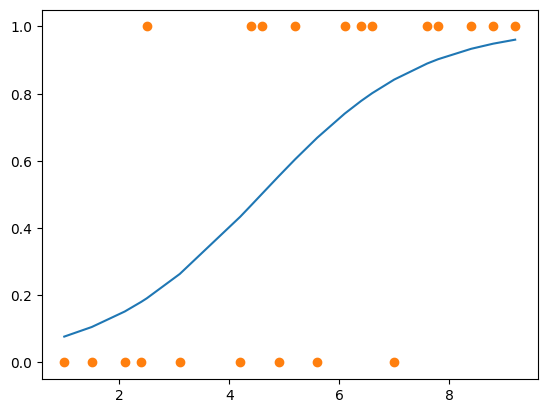

In [39]:
y_hat = model.predict_proba(X)
plt.plot(X, y_hat[:,1])
plt.plot(X,Y,"o")
plt.show()

**Multivariate Logistic Regression**
- multiple input variables
- rest stays the same i think